In [17]:
# Importamos las librerías que necesitaremos a lo largo del código
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px
import plotly.io as pio 
import plotly.graph_objects as go 
import math 
from datetime import timedelta 

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error , mean_absolute_error 

import keras 
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential 
from keras.callbacks import EarlyStopping 

### Visualización (EDA)

In [18]:
df = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates=True, index_col="date")
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [20]:
temp = go.Scatter(x=df.index, y=df['meantemp'], mode='lines', name='Temperature')

# Configuración del layout
layout = go.Layout(
    title='Temperatura media',
    xaxis_title='Fecha',
    yaxis_title='Temperatura media',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)
# Combina los trazos y layout
fig = go.Figure(data=temp, layout=layout)

pio.renderers.default = 'iframe'
# Visualizamos la gráfica
pio.show(fig)

In [21]:
humidity = go.Scatter(
    x=df.index, 
    y=df['humidity'], 
    mode='lines', 
    name='Humidity',
    line=dict(color='red')  
)

# Configuración del layout
layout = go.Layout(
    title='Humedad',
    xaxis_title='Fecha',
    yaxis_title='Humedad',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)
# Combina los trazos y layout
fig = go.Figure(data=[humidity], layout=layout)

# Visualizamos la gráfica
pio.show(fig)

In [42]:
wind_speed = go.Scatter(
    x=df.index, 
    y=df['wind_speed'], 
    mode='lines', 
    name='Wind Speed',
    line=dict(color='purple')  
)

# Configuración del layout
layout = go.Layout(
    title='Velocidad del viento',
    xaxis_title='Fecha',
    yaxis_title='Velocidad del viento',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
    )

# Combina los trazos y layout
fig = go.Figure(data=[wind_speed], layout=layout)

# Visualizamos la gráfica
pio.show(fig)

In [43]:
meanpressure = go.Scatter(
    x=df.index, 
    y=df['meanpressure'], 
    mode='lines', 
    name='Mean Pressure',
    line=dict(color='orange')  
)

# Configuración del layout
layout = go.Layout(
    title='Presión media',
    xaxis_title='Fecha',
    yaxis_title='Presión media',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# # Combina los trazos y layout
fig = go.Figure(data=[meanpressure], layout=layout)

# Visualizamos la gráfica
pio.show(fig)

## Preprocesamiento

In [24]:
dataset = df["meantemp"]
df2 = pd.DataFrame(dataset)
df2.values.shape

(1462, 1)

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df2).reshape(-1, 1))

In [26]:
train_size = int(len(data_scaled) * 0.75)
test_size = len(df2) - train_size 
print(train_size, "/", test_size)

1096 / 366


In [27]:
train_data = data_scaled[:train_size, 0:1]
train_data.shape 

(1096, 1)

In [28]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
               x_train.append(train_data[i-60:i, 0])
               y_train.append(train_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [29]:
# Reshape de la entrada a una matriz 3D [samples, time_steps, features].
x_train = np.reshape(x_train ,(x_train.shape[0], x_train.shape[1], 1))

# Modelo LSTM: justificación

Para predecir la temperatura, decidí usar una RNN LSTM, ya que son buenas capturando patrones a lo largo del tiempo y no sufren tanto del problema del desvanecimiento del gradiente como las RNN normales. Esto es útil porque la temperatura depende mucho de cómo ha variado antes.

El modelo que usé tiene dos capas LSTM apiladas, lo que ayuda a que aprenda patrones más complejos, y al final se agregan capas densas para mejorar la predicción. Para entrenarlo, usé el optimizador Adam porque se adapta bien y no requiere muchos ajustes, además de que funciona bien con redes profundas.

La función de pérdida seleccionada fue el MSE porque penaliza más los errores grandes, lo cual es importante en este tipo de regresión. También usé el MAE como métrica para tener una idea clara del error en grados.

In [30]:
model = Sequential([
    LSTM(50, return_sequences=True,input_shape = (x_train.shape[1], 1) ),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
    
])

model.compile(optimizer= "adam", loss="mse", metrics=["mean_absolute_error"])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


In [32]:
EarlyStopping = EarlyStopping(monitor="loss", patience=15, restore_best_weights=True)
history= model.fit(x_train, y_train, epochs=100, batch_size=32,callbacks = [EarlyStopping])

Epoch 1/100
33/33 [==============================] - 32s 140ms/step - loss: 0.0550 - mean_absolute_error: 0.1654
Epoch 2/100
33/33 [==============================] - 3s 92ms/step - loss: 0.0078 - mean_absolute_error: 0.0710
Epoch 3/100
33/33 [==============================] - 3s 106ms/step - loss: 0.0054 - mean_absolute_error: 0.0583
Epoch 4/100
33/33 [==============================] - 3s 93ms/step - loss: 0.0050 - mean_absolute_error: 0.0558
Epoch 5/100
33/33 [==============================] - 3s 96ms/step - loss: 0.0051 - mean_absolute_error: 0.0564
Epoch 6/100
33/33 [==============================] - 3s 103ms/step - loss: 0.0050 - mean_absolute_error: 0.0555
Epoch 7/100
33/33 [==============================] - 5s 146ms/step - loss: 0.0050 - mean_absolute_error: 0.0556
Epoch 8/100
33/33 [==============================] - 6s 171ms/step - loss: 0.0047 - mean_absolute_error: 0.0538
Epoch 9/100
33/33 [==============================] - 3s 78ms/step - loss: 0.0047 - mean_absolute_error: 0.

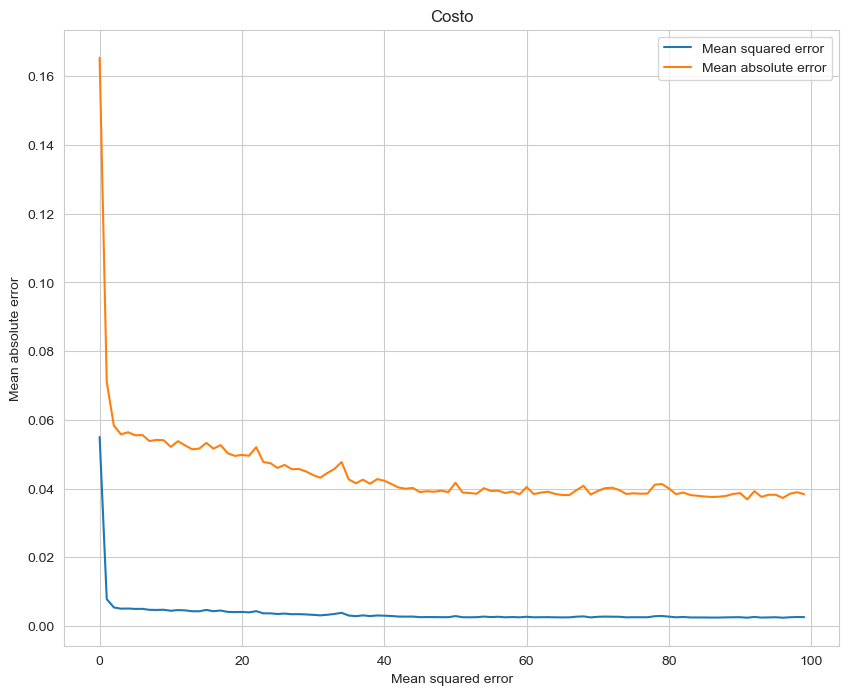

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.title("Costo")
plt.xlabel("Mean squared error")
plt.ylabel("Mean absolute error")
plt.legend(["Mean squared error", "Mean absolute error"])
plt.show()

# Procesamos ahora el subconjunto de datos de prueba para hacer predicciones

In [34]:
test_data = data_scaled[train_size - 60:, :]
x_test = []
y_test = []

for i in range(60, len(test_data)):
               x_test.append(test_data[i-60:i, 0])
               y_test.append(test_data[i, 0])

x_train = np.array(x_test)
y_train = np.array(y_test)

In [35]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
x_test.shape , y_test.shape

((366, 60, 1), (366,))

In [37]:
predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 [==============================] - 3s 24ms/step


(366, 1)

In [38]:
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.58

In [39]:
preds_acts = pd.DataFrame(data={'Predicciones':predictions.flatten(), 'Verdaderas':y_test.flatten()})
preds_acts

,Predicciones,Verdaderas
0,13.952225,14.000000
1,13.420769,14.375000
2,13.473571,15.750000
3,14.336718,15.833333
4,14.665154,17.375000
...,...,...
361,16.106928,17.217391
362,16.373566,15.238095
363,15.188576,14.095238
364,14.121764,15.052632


In [40]:
y_train_flattened = y_train.flatten()

# Creamos un DataFrame con 'train' como nombre de columna
train = pd.DataFrame(data=y_train_flattened, columns=['train'])

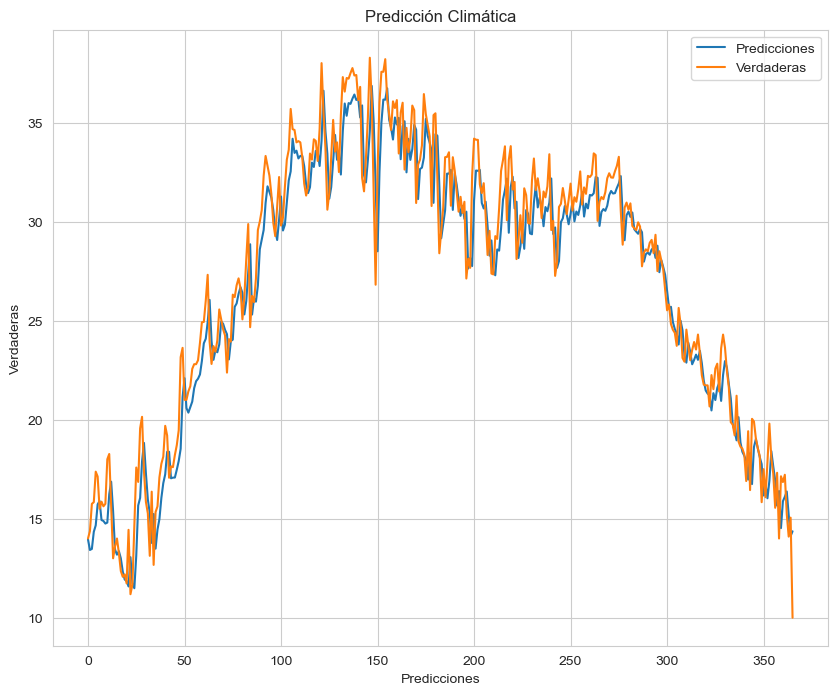

In [41]:
# Visualizamos las predicciones
plt.figure(figsize=(10, 8))
plt.plot(preds_acts["Predicciones"])
plt.plot(preds_acts["Verdaderas"])
plt.title("Predicción Climática")
plt.xlabel("Predicciones")
plt.ylabel("Verdaderas")
plt.legend(["Predicciones", "Verdaderas"])
plt.show()

### Observamos gráficamente que las predicciones son muy cercanas al valor verdadero. Esto confirma que la arquitectura LSTM usando con el optimizador ADAM y la función de costo MSE fueron correctamente elegidas para este modelo de predicción.